In [1]:
import os
repo_dir = os.environ.get("REPO_DIR")
code_dir = os.path.join(repo_dir, "code/")
data_dir = os.path.join(repo_dir, "data/")
os.chdir(code_dir)

import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import pickle
import pandas as pd
import sklearn 
import sys
import pandas as pd
from importlib import reload

import matplotlib

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import seaborn as sns
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

from mosaiks.utils.imports import *
from matplotlib.patches import Patch

import cartopy.crs as ccrs

# Key prediction functions are here
from analysis.prediction_utils import (get_truth_preds_from_kfold_results,
                                            test_train_split, df_to_demeaned_y_vars, 
                                            X_matrix_to_demeaned_X, make_train_pred_scatterplot as make_scatterplot)

In [2]:
## Text save setting for AI
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### First let's look at within-country performance for the best model

In [3]:
## Within country model

model_directory = data_dir + "model_data/"

path = (model_directory+
           "within_country_rcf_and_nl_demeaned_solve_all_outcomes_country_fold"
           "_DENSE_pop_weight=True_dmsp_hist_bins_GPW_pop_weighted.pkl")
nl_and_rcf_demeaned_kfold_dict = pickle.load(open(path, "rb"))


path = (model_directory+
           "within_country_demeaned_kfold_solve_all_outcomes_country_fold_DENSE_pop_weight=True.pkl")
demeaned_kfold_dict = pickle.load(open(path, "rb"))



path = (model_directory+
           "within_country_nl_demeaned_solve_all_outcomes_country_fold_dmsp_hist_bins_GPW_pop_weighted.pkl")
nl_demeaned_kfold_dict = pickle.load(open(path, "rb"))


## Def functions and params

In [4]:
task = "Sub-national HDI"

In [5]:
# Read this just to get country level HDIs

directory = data_dir + "int/GDL_HDI/"

country_df = pd.read_pickle(directory + "HDI_indicators_and_indices_adm0_clean.p")
gpdf_country = pd.read_pickle(directory+"HDI_ADM0_dissolved_shapefile.p").to_crs("ESRI:54030")
country_df[task] = country_df[task].astype(float)

In [20]:
bins =  [0.35,0.5,0.6,0.7,.8,.9,1]

cmap = matplotlib.cm.get_cmap('plasma')

norm = matplotlib.colors.Normalize(vmin=1, vmax=3)

font = {'size'   : 15}

matplotlib.rc('font', **font)

In [21]:
def get_truth_preds_df_from_kfold_dict(kfold_dict, task):
    kfold_results = kfold_dict[task]
    truth, preds = get_truth_preds_from_kfold_results(kfold_results)

    output_indxs = np.hstack(kfold_results["locations_test"])
    
    true_preds = pd.DataFrame({"truth" : truth.flatten(), "preds" : preds.flatten()}, index=output_indxs)
    true_preds["country"] = pd.Series(output_indxs).apply(lambda x: x[:3]).to_numpy()
    
    return true_preds

In [22]:
def get_binned_performance(kfold_dict, task, bins = [0.35,0.5,0.6,0.7,.8,.9,1], 
                               df = country_df, truth_key="Sub-national HDI", log_truth=False, 
                           match_to_country=True, metric="r2_score"):
    """
    bins includes the left and right bounds on the set of bins
    
    """
    
    truths = df[[truth_key]]
    
    if log_truth:
        truths = np.log10(truths)
    
    true_preds = get_truth_preds_df_from_kfold_dict(kfold_dict, task)
    
    binned_r2s = []
    n_obs = []
    
    for i in range(len(bins)-1):
        indxs = truths[ (truths[truth_key] >= bins[i]) & (truths[truth_key] < bins[i+1] )].index
        
        if match_to_country:
            binned = true_preds[true_preds["country"].isin(indxs)]
            n_obs.append(len(indxs))
    
        else:
            binned = true_preds[true_preds.index.isin(indxs)]
            n_obs.append(len(binned))
        
        if metric == "r2_score":
            binned_r2s.append(sklearn.metrics.r2_score(binned["truth"], binned["preds"]))
        elif metric == "pearson":
            binned_r2s.append(np.corrcoef(binned["truth"], binned["preds"])[0,1])
        else: raise NotImplementedError
        
    return binned_r2s, n_obs

In [23]:
def binned_metrics_from_df(df, bins=bins, truth_df=country_df, truth_key="Sub-national HDI", 
                           log_truth=False, match_to_country=True, metric="r2_score"):
    
    truths = truth_df[[truth_key]]
    
    if log_truth:
        truths = np.log10(truths)

    binned_r2s = []
    n_obs = []
    binned_rs = []

    for i in range(len(bins)-1):
        indxs =truths[ (truths[truth_key] >= bins[i]) & (truths[truth_key] < bins[i+1] )].index
        
        if match_to_country:
            binned = df[df["alpha-3"].isin(indxs)]
            n_obs.append(len(binned))
    
        else:
            binned = df[df.index.isin(indxs)]
            n_obs.append(len(binned))
        
        
        if len(binned) == 0:
            binned_r2s.append(0)
            binned_rs.append(0)
            continue
            
        if metric == "r2_score":
            binned_r2s.append(sklearn.metrics.r2_score(binned["true_demean_adm1"], binned["preds_demean_adm1"]))
        elif metic == "pearson":
            binned_rs.append(np.corrcoef(binned["true_demean_adm1"], binned["preds_demean_adm1"])[0,1])
        else:
            raise NotImplementedError
    
    return binned_rs, binned_r2s, n_obs

## Analysis of HDI heterogeneity for  within-ADM0 models

In [24]:
demeaned_R2s, n_obs = get_binned_performance(demeaned_kfold_dict, task, bins=bins, df=country_df, 
                                             match_to_country=True)

nl_demeaned_R2s, _ = get_binned_performance(nl_demeaned_kfold_dict, task, bins=bins, df=country_df)

nl_rcf_R2s, _ = get_binned_performance(nl_and_rcf_demeaned_kfold_dict, task, bins=bins, df=country_df)

In [25]:
demeaned_R2s, n_obs = get_binned_performance(nl_and_rcf_demeaned_kfold_dict, task, bins=bins, df=country_df, 
                                             match_to_country=True)


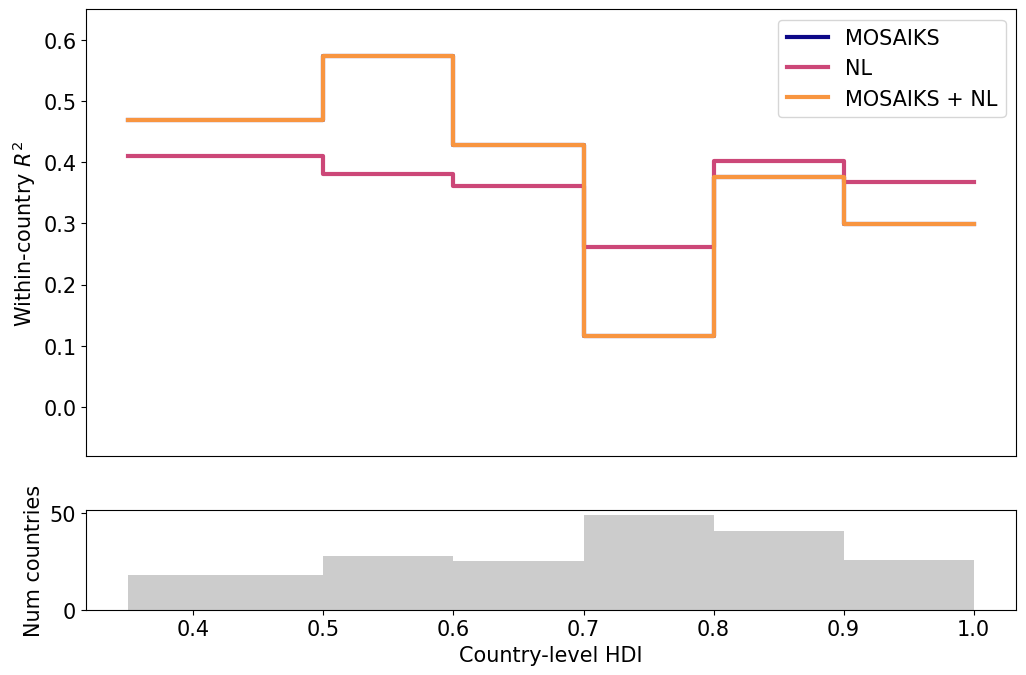

In [26]:
fig, ax = plt.subplots(2,1, figsize=(20*.6,13*.6), gridspec_kw={'height_ratios': [4.5, 1]},)
#ax2 = ax.twinx()

#x_axis = np.array(np.array([bins[1:], bins[:-1]]).mean(axis=0))
x_axis = np.array(bins)


ax[0].step(x_axis,  [demeaned_R2s[0]]+demeaned_R2s, label = "MOSAIKS", color = cmap(norm(1)), linewidth=3)
ax[0].step(x_axis,  [nl_demeaned_R2s[0]]+nl_demeaned_R2s,  label = "NL", color = cmap(norm(2)), linewidth=3)
ax[0].step(x_axis,  [nl_rcf_R2s[0]]+ nl_rcf_R2s, label = "MOSAIKS + NL", color = cmap(norm(2.5)), linewidth=3)

ax[0].legend()
ax[0].set_ylabel("Within-country $R^2$")
ax[1].set_xlabel("Country-level HDI")
#ax.set_title("Demeaned $R^2$ performance by HDI bin")
ax[0].set_ylim(-.08,0.65)
ax[0].xaxis.set_visible(False)


ax[1].bar( bins[:-1], height = n_obs,width= np.array(bins[1:])-np.array(bins[:-1]), color="gray", alpha=0.4, align="edge")
ax[1].set_ylabel("Num countries")

fig.savefig(repo_dir + "figures/HDI_heterogeneity.pdf", dpi=300)



## Let's add a map of heterogeneity

First, we need to get our out of sample test set predictions

In [27]:
path = data_dir + "preds/hdi_test_set_preds_df_demean_rcf_nl.p"
test_preds = pd.read_pickle(path)
test_preds = test_preds.drop(columns = ["truth", "preds","add_back_country_mean",
                                        "true country mean", "pred country mean"])

test_preds = test_preds.rename(columns = {"preds_demean":"preds", "true_demean":"truth"})

test_preds["country"] = pd.Series(test_preds.index).apply(lambda x: x[:3]).to_numpy()
test_preds.index.name = None

In [28]:
true_pred = get_truth_preds_df_from_kfold_dict(nl_and_rcf_demeaned_kfold_dict, task)

In [29]:
df = pd.concat([true_pred, test_preds], axis=0)

In [30]:
within_adm0_r2s = {}
within_adm0_pearson = {}
country_sd = {}

for country in df["country"].unique():
    subset = df[df["country"] == country]
    
    if len(subset) < 2:
        within_adm0_pearson[country] = np.nan
        within_adm0_r2s[country] = np.nan
        country_sd[country] = np.nan
        
    else:
        within_adm0_r2s[country] = sklearn.metrics.r2_score(subset["truth"], subset["preds"])
        within_adm0_pearson[country] = np.corrcoef(subset["truth"], subset["preds"])[0,1]
        country_sd[country] = np.std(subset["truth"])
    

In [31]:
metrics = pd.DataFrame([within_adm0_r2s,within_adm0_pearson,country_sd]).T.rename(columns = {0:"r2",1:"pearson",2:"sd"})

In [32]:
gpdf_country_adm = gpdf_country.merge(metrics, "left", left_index=True,right_index=True)

### Maps of within-ADM0 performance heterogeneity

#### R2

In [33]:
legend_elements = [ Patch(facecolor='#966919', alpha=1, hatch = "//",
                         label='$R^{2}$ < 0'),
                  Patch(facecolor='#D3D3D3', alpha=1,
                         label='No provincial observations')
]

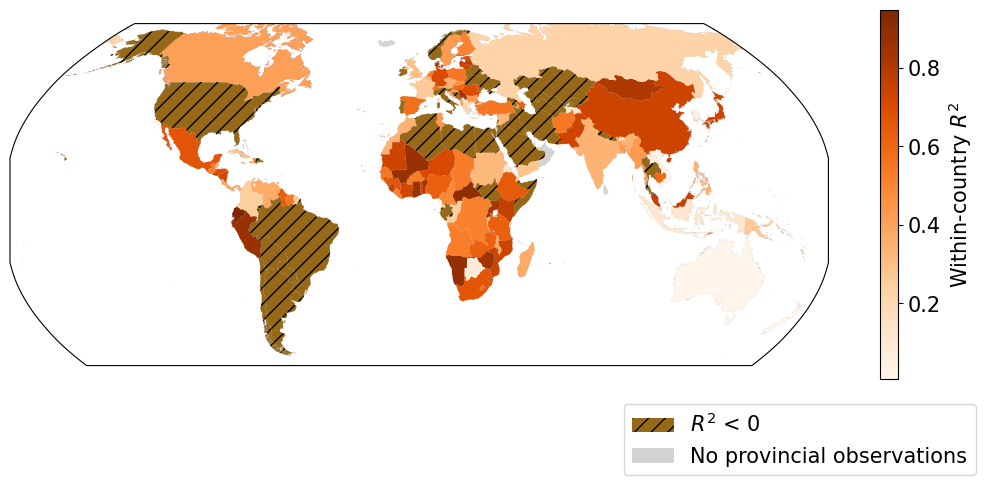

In [34]:
# map of r2 heterogeneity 

rasterized= True

fig, ax = plt.subplots(1, figsize = (11*1.2,4*1.2),subplot_kw={'projection':ccrs.Robinson()})

gpdf_country_adm.plot(color = "#D3D3D3", rasterized=rasterized, ax=ax) #background gray

neg_subset = gpdf_country_adm[gpdf_country_adm["r2"] < 0] #Where peformance is negative
subset = gpdf_country_adm [gpdf_country_adm ["r2"] > 0 ] # Where performance is positive, with color bar

subset.plot(ax=ax, cmap="Oranges", legend=True, column="r2",rasterized=rasterized,
            legend_kwds = {"label": "Within-country $R^{2}$"})

neg_subset.plot(ax=ax, color="#966919",alpha=1, label="<0", rasterized=rasterized, hatch="//")

ax.set_extent((-180,180,-60,74),ccrs.PlateCarree())


ax.legend(handles=legend_elements, loc = (.75,-.32))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)


fig.savefig(repo_dir + "figures/within-ADM0_HDI_mapped_heterogeneity.pdf", 
            dpi=300,bbox_inches='tight')

## Map of SDs

In [35]:
legend_elements = [ 
                  Patch(facecolor='#D3D3D3', alpha=1,
                         label='No provincial observations')
]

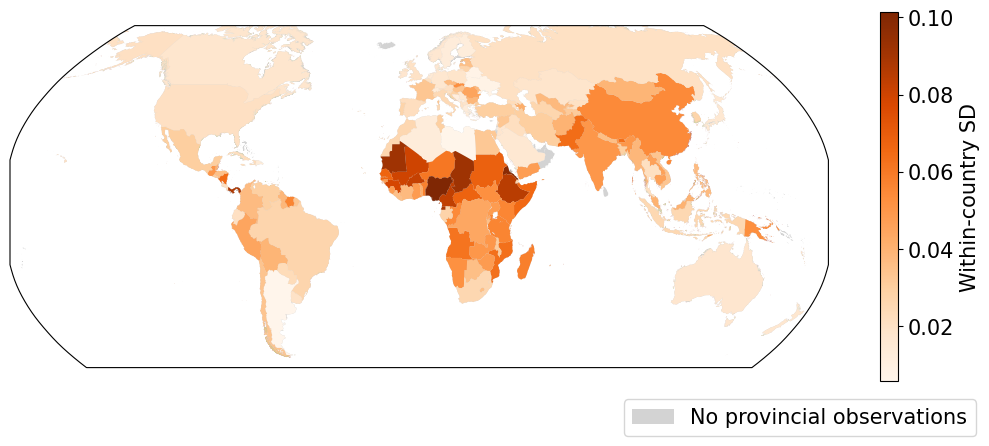

In [36]:
## map of r2 heterogeneity 

rasterized= True

fig, ax = plt.subplots(1, figsize = (11*1.2,4*1.2),subplot_kw={'projection':ccrs.Robinson()})

gpdf_country_adm.plot(color = "#D3D3D3", rasterized=rasterized, ax=ax) #background gray

subset = gpdf_country_adm[gpdf_country_adm["sd"] > 0] #Where peformance is negative

subset.plot(ax=ax, cmap="Oranges", legend=True, column="sd",rasterized=rasterized,
            legend_kwds = {"label": "Within-country SD"})
#ax.set_xlim(-180,180)

ax.set_extent((-180,180,-60,74),ccrs.PlateCarree())

ax.legend(handles=legend_elements, loc = (.75,-.2))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)


fig.savefig(repo_dir + "figures/within-ADM0_HDI_SD_mapped.pdf", 
            dpi=300,bbox_inches='tight')

## Now let's examine Heterogeneity of DHS cluster preds

In [37]:
path = data_dir + "preds/demean_iwi_rcf_nl_at_dhs.p"
dhs = pd.read_pickle(path)

path =  data_dir + "preds/demean_iwi_rcf_at_dhs.p"
dhs_rcf = pd.read_pickle(path)

path =  data_dir + "preds/demean_iwi_nl_at_dhs.p"
dhs_nl = pd.read_pickle(path)

In [38]:
r2_perf = {}
pearson_perf = {}
within_adm1_sd = {}

for country in dhs["alpha-3"].unique():
    subset = dhs[dhs["alpha-3"] == country]
    r2_perf[country] = sklearn.metrics.r2_score(subset["true_demean_adm1"],subset["preds_demean_adm1"])
    pearson_perf[country] = np.corrcoef(subset["true_demean_adm1"],subset["preds_demean_adm1"])[0,1]
    within_adm1_sd[country] = np.std(subset["true_demean_adm1"])
    

## Now we just map DHS performance

In [24]:
gpdf_dhs = gpdf_country.join(pd.Series(r2_perf).rename("r2"), how="inner")

### R2

In [25]:
legend_elements = [                    Patch(facecolor='#966919', alpha=1, hatch = "//",
                         label=r'$R^{2}$ < 0'),
                   Patch(facecolor='#D3D3D3', alpha=1,
                          label = "No DHS data")
                  ]


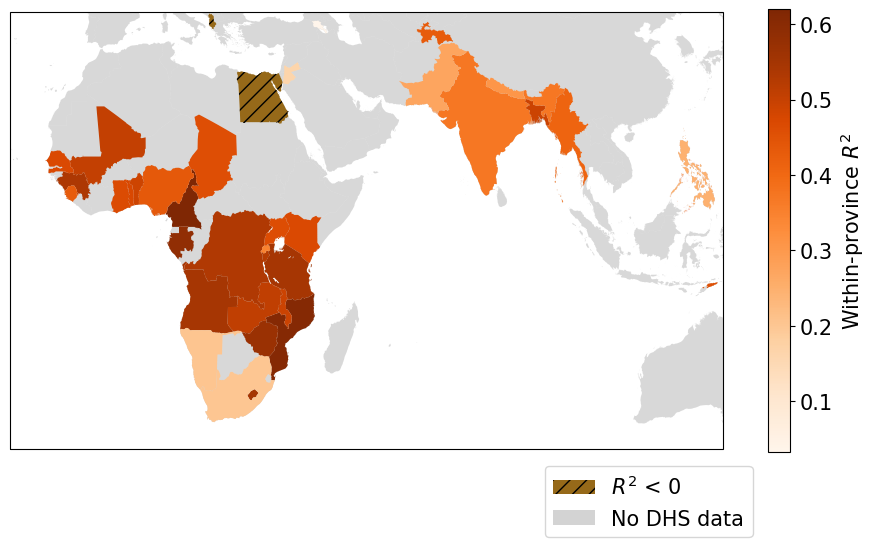

In [26]:
rasterized = True

fig, ax = plt.subplots(1, figsize = (10*1.15,5*1.15),subplot_kw={'projection':ccrs.Robinson()})

subset = gpdf_dhs[gpdf_dhs["r2"] >= 0]

neg_subset = gpdf_dhs[gpdf_dhs["r2"] < 0]

gpdf_country.plot(color="gray", alpha=0.3, ax=ax, rasterized=rasterized)

subset.plot(ax=ax, column = "r2", legend=True, legend_kwds = {"label":r"Within-province $R^{2}$"},
            cmap="Oranges", rasterized=rasterized)

neg_subset.plot(ax=ax, color = "#966919", rasterized=rasterized, hatch="//")

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax.legend(handles = legend_elements,loc = (.75,-.2))

ax.set_xlim(-25,128)
ax.set_ylim(-40,43)

ax.set_extent((-25,128,-40,43), ccrs.PlateCarree())

fig.savefig(repo_dir + "figures/within-ADM1_IWI_mapped_perf.pdf", 
            dpi=300,bbox_inches='tight')

In [27]:
legend_elements = [ 
                  Patch(facecolor='#D3D3D3', alpha=1,
                         label='No DHS observations')
]

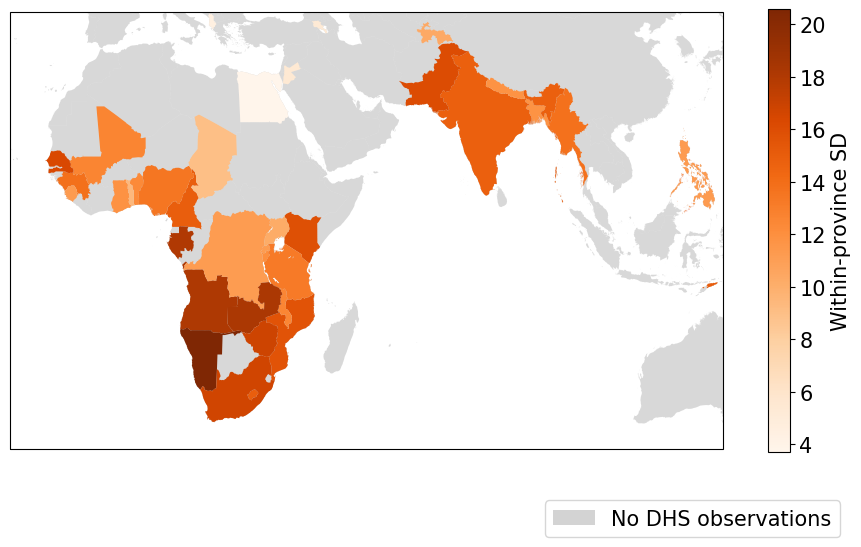

In [28]:
## Now make SD
gpdf_dhs = gpdf_country.join(pd.Series(within_adm1_sd).rename("sd"), how="inner")


rasterized = True

fig, ax = plt.subplots(1, figsize = (10*1.15,5*1.15),subplot_kw={'projection':ccrs.Robinson()})

subset = gpdf_dhs[gpdf_dhs["sd"] >= 0]


gpdf_country.plot(color="gray", alpha=0.3, ax=ax, rasterized=rasterized)

subset.plot(ax=ax, column = "sd", legend=True, legend_kwds = {"label":r"Within-province SD"},
            cmap="Oranges", rasterized=rasterized)


ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

ax.legend(handles = legend_elements,loc = (.75,-.2))

# ax.set_xlim(-25,128)
# ax.set_ylim(-40,43)

ax.set_extent((-25,128,-40,43), ccrs.PlateCarree())

fig.savefig(repo_dir + "figures/within-ADM1_IWI_SD_mapped.pdf", 
            dpi=300,bbox_inches='tight')


### Bin by HDI

In [29]:
binned_rs_rcf_and_nl, binned_r2s_rcf_and_nl , n_obs = binned_metrics_from_df(dhs, bins, match_to_country=True)
binned_rs_rcf, binned_r2s_rcf , _ = binned_metrics_from_df(dhs_rcf, bins)
binned_rs_nl, binned_r2s_nl, _ = binned_metrics_from_df(dhs_nl, bins)

In [30]:
binned_r2s_rcf_and_nl

[0.5165115134350627,
 0.4767597401408866,
 0.372595469910905,
 0.24370959441067175,
 -0.5468372150684082,
 0]

In [31]:
n_obs

[3258, 10102, 32007, 5914, 715, 0]

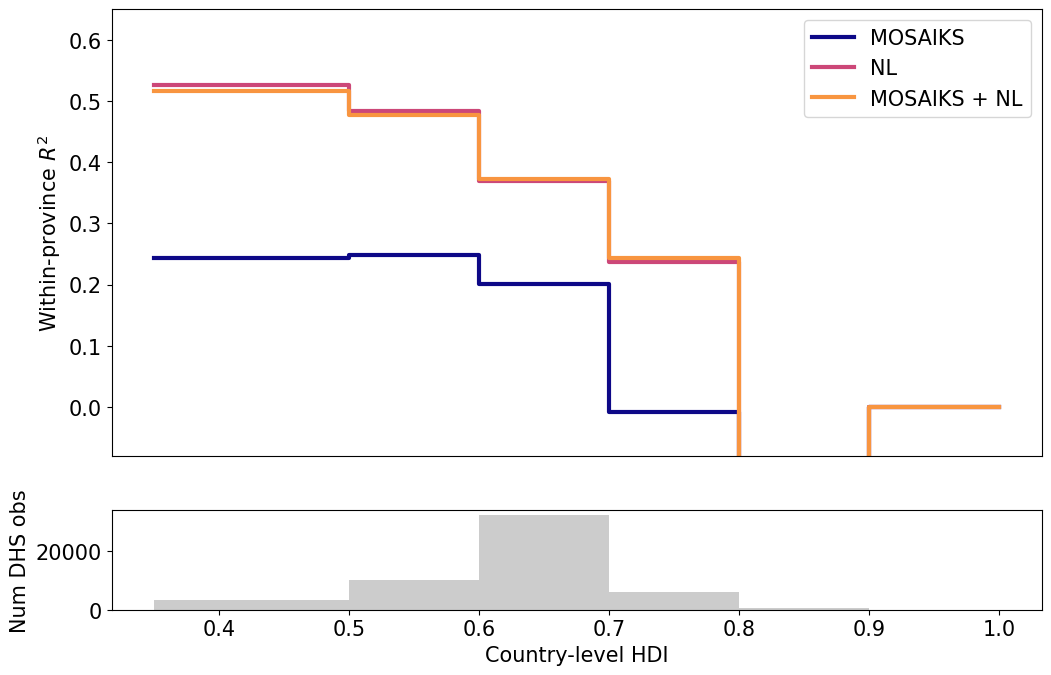

In [32]:
fig, ax = plt.subplots(2,1, figsize=(20*.6,13*.6), gridspec_kw={'height_ratios': [4.5, 1]})
#ax2 = ax.twinx()

#x_axis = np.array(np.array([bins[1:], bins[:-1]]).mean(axis=0))
x_axis = np.array(bins)

ax[0].step(x_axis,  [binned_r2s_rcf[0]]+binned_r2s_rcf, label = "MOSAIKS", color = cmap(norm(1)), linewidth=3)
ax[0].step(x_axis,  [binned_r2s_nl[0]]+binned_r2s_nl,  label = "NL", color = cmap(norm(2)), linewidth=3)
ax[0].step(x_axis,  [binned_r2s_rcf_and_nl[0]]+ binned_r2s_rcf_and_nl, label = "MOSAIKS + NL", color = cmap(norm(2.5)), linewidth=3)



ax[0].legend()
ax[0].set_ylabel("Within-province $R^{2}$")
ax[0].set_xlabel("Country-level HDI")
#ax.set_title("Demeaned $R^2$ performance by HDI bin")
ax[0].set_ylim(-0.08,0.65)
ax[0].xaxis.set_visible(False)

ax[1].bar( bins[:-1], height = n_obs,width= np.array(bins[1:])-np.array(bins[:-1]), color="gray", alpha=0.4, align="edge")
ax[1].set_ylabel("Num DHS obs")
ax[1].set_xlabel("Country-level HDI")

#ax[0].set_title("IWI at DHS cluster level  \n Within-ADM1 performance")

fig.savefig(repo_dir + "figures/dhs_iwi_binned_by_hdi.pdf", dpi=300)


In [33]:
import statsmodels.api as sm

In [34]:
sm.OLS(metrics["pearson"]**2,metrics["sd"]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                pearson   R-squared (uncentered):                   0.682
Model:                            OLS   Adj. R-squared (uncentered):              0.680
Method:                 Least Squares   F-statistic:                              338.6
Date:                Thu, 03 Aug 2023   Prob (F-statistic):                    3.93e-41
Time:                        11:36:04   Log-Likelihood:                         -51.751
No. Observations:                 159   AIC:                                      105.5
Df Residuals:                     158   BIC:                                      108.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sd            11.7169      0.637     18.401      0.000      10.459      12.975
==============================================================================
Omnibus:                        2.700   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.259   Jarque-Bera (JB):                2.299
Skew:                          -0.282   Prob(JB):                        0.317
Kurtosis:                       3.171   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
sm.OLS(metrics["pearson"]**2,metrics["sd"]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                pearson   R-squared (uncentered):                   0.682
Model:                            OLS   Adj. R-squared (uncentered):              0.680
Method:                 Least Squares   F-statistic:                              338.6
Date:                Thu, 03 Aug 2023   Prob (F-statistic):                    3.93e-41
Time:                        11:36:04   Log-Likelihood:                         -51.751
No. Observations:                 159   AIC:                                      105.5
Df Residuals:                     158   BIC:                                      108.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sd            11.7169      0.637     18.401      0.000      10.459      12.975
==============================================================================
Omnibus:                        2.700   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.259   Jarque-Bera (JB):                2.299
Skew:                          -0.282   Prob(JB):                        0.317
Kurtosis:                       3.171   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
np.corrcoef(metrics["pearson"]**2,metrics["sd"]) 

array([[1.        , 0.25159829],
       [0.25159829, 1.        ]])

In [44]:
dhs_metrics = pd.DataFrame([pearson_perf,within_adm1_sd]).T.rename(columns = {0:"p",1:"sd"})

In [45]:
np.corrcoef(dhs_metrics["p"]**2,dhs_metrics["sd"])

array([[1.        , 0.48338767],
       [0.48338767, 1.        ]])

In [40]:
sm.OLS(dhs_metrics["p"]**2,dhs_metrics["sd"]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      p   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              387.2
Date:                Thu, 03 Aug 2023   Prob (F-statistic):                    1.59e-21
Time:                        11:36:04   Log-Likelihood:                          21.636
No. Observations:                  39   AIC:                                     -41.27
Df Residuals:                      38   BIC:                                     -39.61
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sd             0.0330      0.002     19.677      0.000       0.030       0.036
==============================================================================
Omnibus:                       21.841   Durbin-Watson:                   1.613
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.637
Skew:                          -1.615   Prob(JB):                     8.18e-08
Kurtosis:                       6.106   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""